# EJERCICIO

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos de propinas que viene en la librería seaborn para intentar predecir que propina dejará una persona a partir de ciertos datos como sexo, importe...**

**Como criterio de evaluación vamos a usar RCME.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer

In [2]:
df_tips = sns.load_dataset('tips')

Significado de las columnas:
1. `total_bill`: Esta columna representa el monto total de la factura de una transacción en el restaurante, incluyendo la comida y las bebidas.

2. `tip`: En esta columna se registra la cantidad de propina que se dio en esa transacción.

3. `sex`: Indica el sexo del camarero o camarera que atendió la mesa (por ejemplo, "Male" para masculino y "Female" para femenino).

4. `smoker`: Esta columna indica si los comensales eran fumadores o no fumadores en la mesa (por ejemplo, "Yes" para fumadores y "No" para no fumadores).

5. `day`: Registra el día de la semana en el que se realizó la transacción (por ejemplo, "Thur" para jueves, "Fri" para viernes, "Sat" para sábado y "Sun" para domingo).

6. `time`: Indica si la transacción fue durante el almuerzo o la cena (por ejemplo, "Lunch" para almuerzo y "Dinner" para cena).

7. `size`: Representa el número de comensales en la mesa.

### EXPLORAR LOS DATOS

In [3]:
df_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [4]:
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df_tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


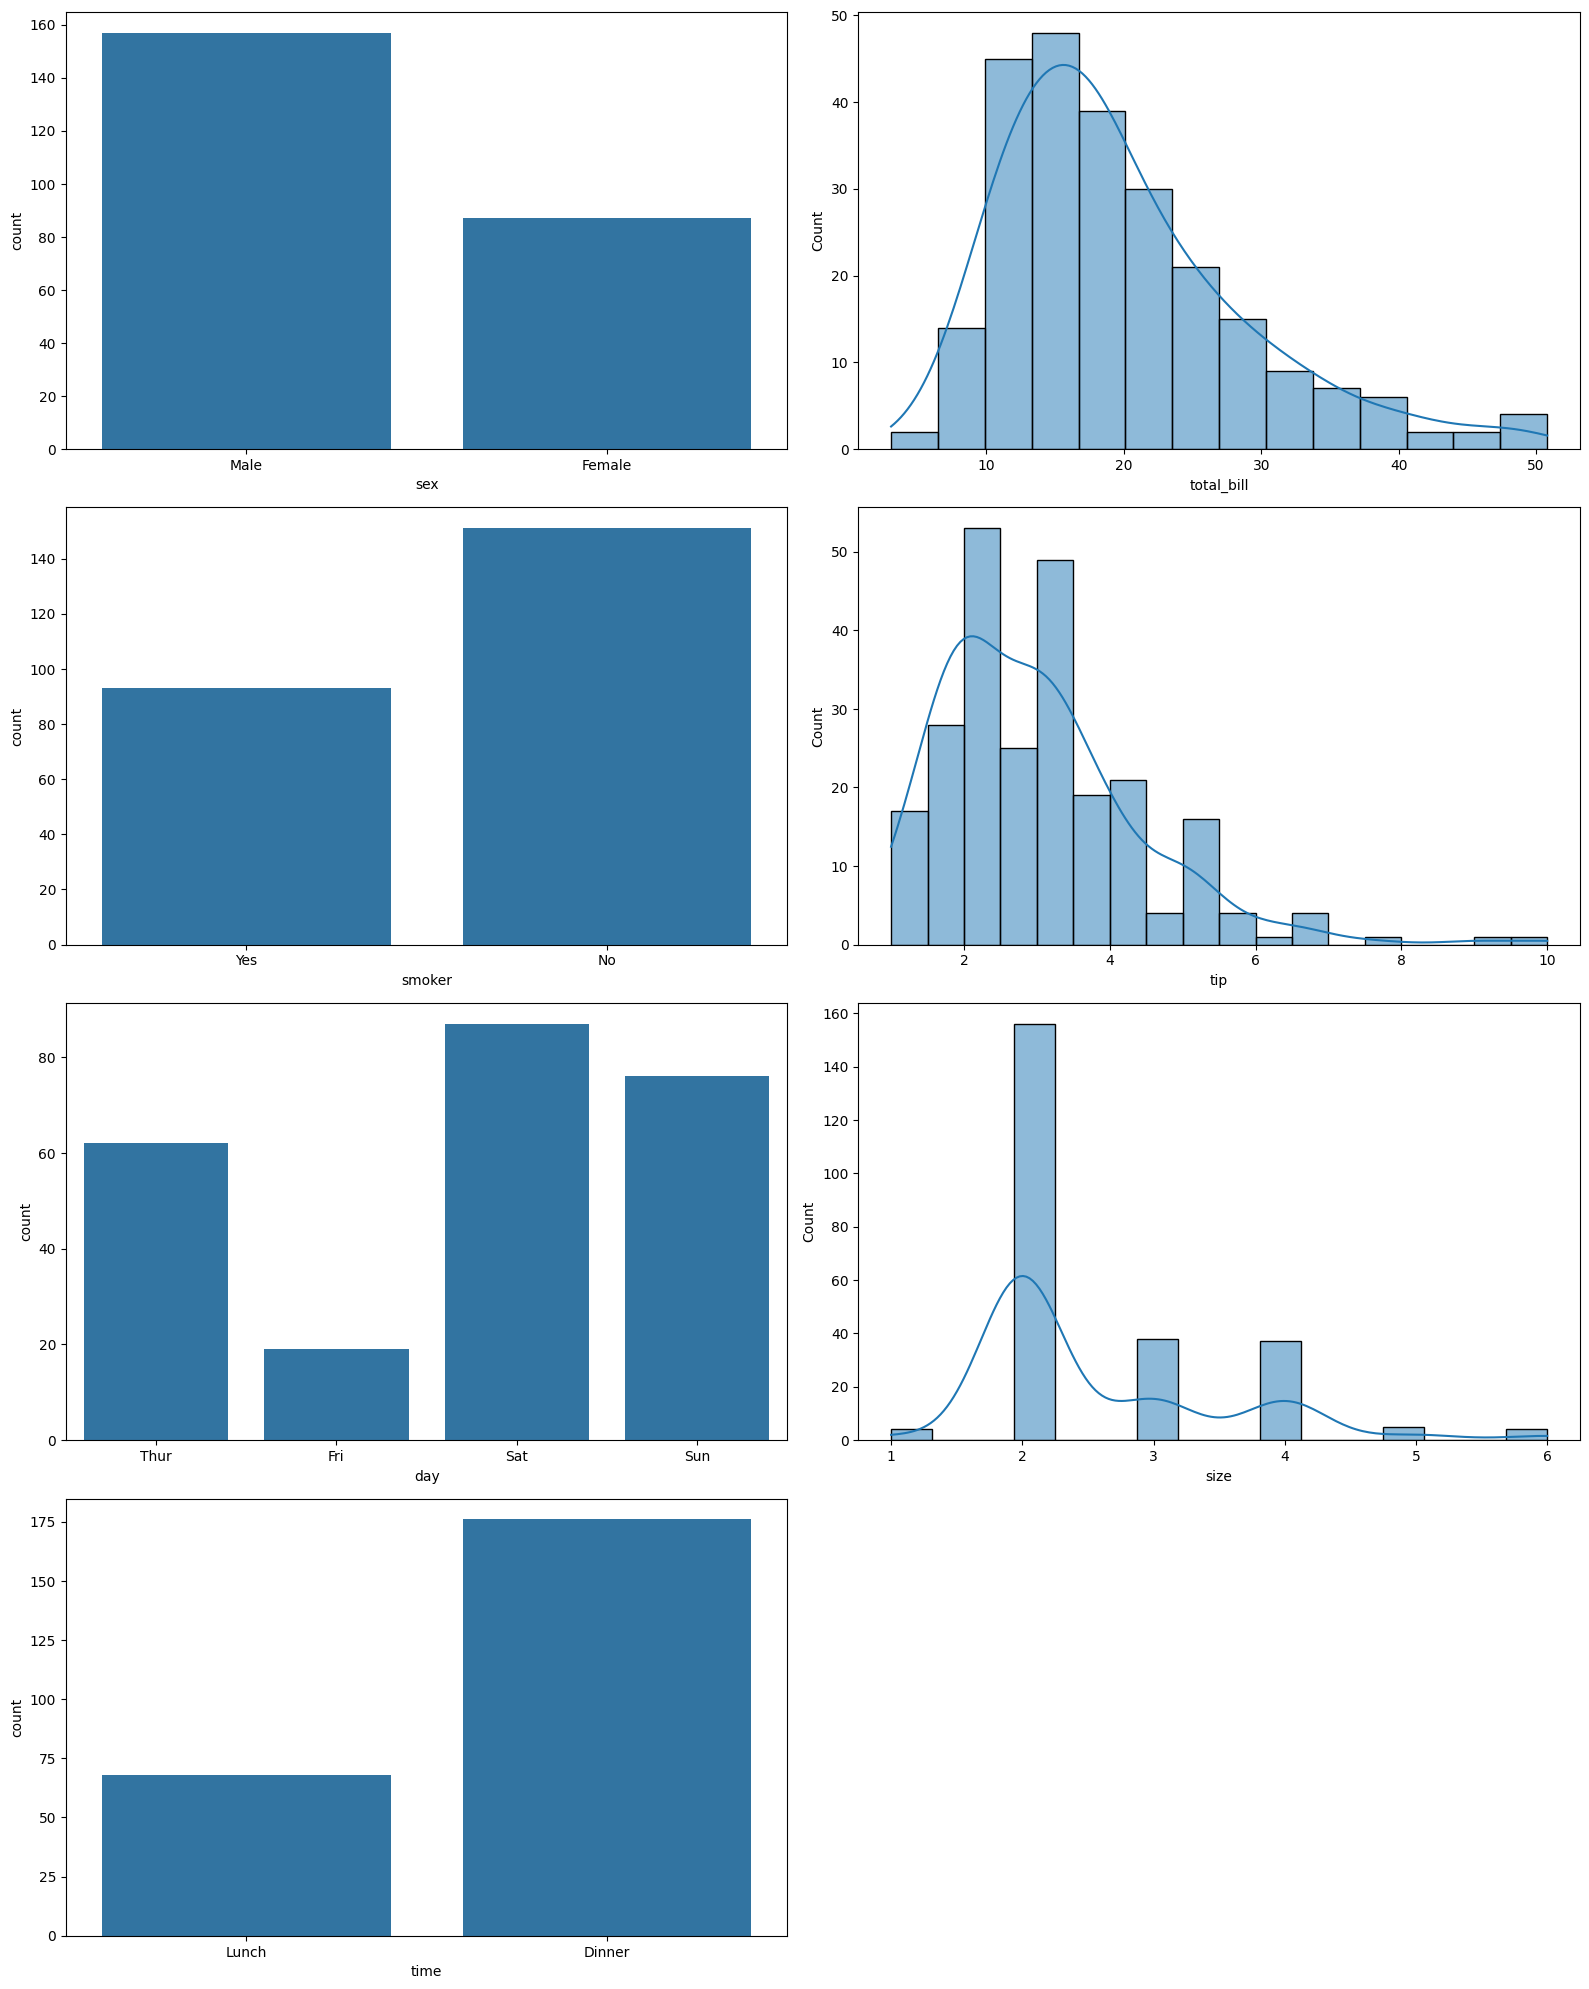

In [6]:
# Definir las variables categóricas y continuas (usamos solo 7 variables)
categorical_vars = ['sex', 'smoker', 'day', 'time']
continuous_vars = ['total_bill', 'tip', 'size']

# Crear una figura con 8 subgráficos (4x2)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

# Graficar las variables categóricas
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df_tips, x=var, ax=axes[i, 0])

# Graficar las variables continuas
for i, var in enumerate(continuous_vars):
    sns.histplot(data=df_tips, x=var, ax=axes[i, 1], kde=True)

# Eliminar el último subgráfico vacío
fig.delaxes(axes[3, 1])

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()
plt.show()

### DIVIDIR LOS DATOS

In [7]:
strat_train_set, strat_test_set = train_test_split(df_tips, test_size=0.15, stratify=df_tips["day"], random_state=42)

### PREPARAR LOS DATOS

In [8]:
def encode_sex(X):
    X['sex'] = np.where(X['sex'] == 'Male', 0, 1)
    return X

def encode_smoker(X):
    X['smoker'] = np.where(X['smoker'] == 'No', 0, 1)
    return X

def encode_time(X):
    X['time'] = np.where(X['time'] == 'Lunch', 0, 1)
    return X


sex_pipeline = make_pipeline(
    FunctionTransformer(encode_sex, feature_names_out="one-to-one"))

smoker_pipeline = make_pipeline(
    FunctionTransformer(encode_smoker, feature_names_out="one-to-one"))

day_pipeline = make_pipeline(
    OneHotEncoder()  
)
time_pipeline = make_pipeline(
    FunctionTransformer(encode_time, feature_names_out="one-to-one"))

preprocessing = ColumnTransformer([
        ("sex_transform", sex_pipeline, ["sex"]),
        ("smoker_transform", smoker_pipeline, ["smoker"]),
        ("day_transform", day_pipeline, ["day"]),
        ("time_transform", time_pipeline, ["time"])
    ],remainder=StandardScaler(),verbose_feature_names_out = False)

In [9]:
tips_prepared = preprocessing.fit_transform(strat_test_set)
preprocessing.get_feature_names_out()

array(['sex', 'smoker', 'day_Fri', 'day_Sat', 'day_Sun', 'day_Thur',
       'time', 'total_bill', 'tip', 'size'], dtype=object)

In [10]:
tips_prepared_fr = pd.DataFrame(
    tips_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=strat_test_set.index)
tips_prepared_fr.head()

,sex,smoker,day_Fri,day_Sat,day_Sun,day_Thur,time,total_bill,tip,size
118,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.841772,-0.800890,-0.621699
107,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.597951,0.878737,-0.621699
40,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.435090,-0.504089,0.588978
49,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.209781,0.008569,-0.621699
11,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.730128,1.357667,1.799655


## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

No hacer de momento

## OPTIMIZACIÓN DEL MODELO

No hacer de momento

### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

No hacer de momento

## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.